Ahmad Luay Adnani

[Dashboard](https://lookerstudio.google.com/reporting/59d8caaa-d65c-4e7d-b30b-07bda9423e22)

[github](https://github.com/ahmadluay9/Shipping-and-Stock-Performace-of-the-look-ecommerce)

# 1 - Introduction

> This section contains the background , problem statement and objective.

## 1.1 Background

"The Look Ecommerce" is an online retail company specializing in fashion and beauty products. As an e-commerce business, its success heavily relies on efficient shipping processes and optimal stock management. Customers in the fast-paced digital marketplace expect timely deliveries and a wide variety of products in stock. To maintain a competitive edge, "The Look Ecommerce" needs to continuously assess and improve its shipping and stock performance to enhance customer satisfaction, reduce operational costs, and stay ahead of the competition.

## 1.2 Objectives

The objective of this project is to assess the shipping and stock performance of The Look Ecommerce. The analysis carried out includes:

1. find out the best-selling product categories.
2. find out the best-selling brands.
3. find out the name of the best-selling product.

By achieving this objectives, "The Look Ecommerce" aims to elevate its shipping and stock performance, creating a seamless shopping experience for its customers, optimizing operational efficiency, and strengthening its position as a leading player in the competitive e-commerce industry.

# 2 - Import Library

> This section explains how to import the libraries that will be used in this notebook.

In [125]:
# Import Libraries
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

project_id = "ftds-hacktiv8-project-380618"
client = bigquery.Client(project=project_id)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Libraries Version
print("Pandas version: ",pd.__version__)
print("numpy version: ",np.__version__)
print("matplotlib version: ",matplotlib.__version__)
print("seaborn version: ",sns.__version__)

Authenticated
Pandas version:  1.5.3
numpy version:  1.22.4
matplotlib version:  3.7.1
seaborn version:  0.12.2


# 3 - Data Loading

> This section explains the process of data loading.

## 3.1 Data Loading
Dataset obtained from the BigQuery database "thelook_ecommerce" Q1 - Q2 2023

In [126]:
# Query
df = client.query('''
SELECT
  inventory.id,
  inventory.product_id,
  inventory.created_at,
  inventory.product_category,
  inventory.product_name,
  inventory.product_brand,
  orders.num_of_item,
  SUM(oi.sale_price) AS total_revenue,
  COUNT(DISTINCT CASE WHEN oi.status = 'Shipped' THEN oi.order_id END) AS num_shipped_orders,
  COUNT(DISTINCT CASE WHEN oi.status = 'Complete' THEN oi.order_id END) AS num_delivered_orders,
  COUNT(DISTINCT CASE WHEN oi.status = 'Processing' THEN oi.order_id END) AS num_processed_orders,
  COUNT(DISTINCT CASE WHEN oi.status = 'Returned' THEN oi.order_id END) AS num_returned_orders
FROM (
  SELECT *,
         EXTRACT(YEAR FROM created_at) AS year,
         EXTRACT(MONTH FROM created_at) AS month
  FROM `bigquery-public-data.thelook_ecommerce.inventory_items`
  WHERE created_at BETWEEN "2023-01-01" AND "2023-06-30"
) AS inventory
LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi
ON inventory.product_id = oi.product_id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.orders` AS orders
ON oi.order_id = orders.order_id
WHERE inventory.year = 2023 AND inventory.month IN (1, 2, 3, 4, 5, 6)
GROUP BY
  inventory.id,
  inventory.product_id,
  inventory.created_at,
  inventory.product_category,
  inventory.product_name,
  inventory.product_brand,
  orders.num_of_item
ORDER BY
  created_at ASC;
''').to_dataframe()

# set_options
pd.set_option("display.max_columns", 25)
pd.set_option("display.max_rows", 25)
pd.set_option("display.max_colwidth", 1000)

# Palette color
palette = 'rocket'

In [127]:
# Data loading
df.head(10)

,id,product_id,created_at,product_category,product_name,product_brand,num_of_item,total_revenue,num_shipped_orders,num_delivered_orders,num_processed_orders,num_returned_orders
0,168866,10949,2023-01-01 00:00:00+00:00,Intimates,Hanky Panky Signature Lace Hello Kitty Low Rise Thong (49KITTY),Hanky Panky,1,81.000000,1,0,0,1
1,168866,10949,2023-01-01 00:00:00+00:00,Intimates,Hanky Panky Signature Lace Hello Kitty Low Rise Thong (49KITTY),Hanky Panky,2,27.000000,0,0,0,1
2,168866,10949,2023-01-01 00:00:00+00:00,Intimates,Hanky Panky Signature Lace Hello Kitty Low Rise Thong (49KITTY),Hanky Panky,4,27.000000,0,1,0,0
3,182516,1491,2023-01-01 00:03:00+00:00,Sweaters,Sutton Studio Women's Anorak Cardigan,Sutton Studio,2,519.960022,1,1,1,0
4,182516,1491,2023-01-01 00:03:00+00:00,Sweaters,Sutton Studio Women's Anorak Cardigan,Sutton Studio,1,259.980011,1,0,1,0
5,318396,12279,2023-01-01 00:06:00+00:00,Intimates,Alivila.Y Fashion Sexy Lace Lingerie Sleepwear Robe Set Kimono With G-String 538,Alivila.Y Fashion,1,69.929998,2,3,1,0
6,318396,12279,2023-01-01 00:06:00+00:00,Intimates,Alivila.Y Fashion Sexy Lace Lingerie Sleepwear Robe Set Kimono With G-String 538,Alivila.Y Fashion,2,29.969999,1,2,0,0
7,318396,12279,2023-01-01 00:06:00+00:00,Intimates,Alivila.Y Fashion Sexy Lace Lingerie Sleepwear Robe Set Kimono With G-String 538,Alivila.Y Fashion,3,19.980000,0,2,0,0
8,7202,9950,2023-01-01 00:07:00+00:00,Sleep & Lounge,Hello Kitty Women's Hk Graphic Cheer Night Shirt,Hello Kitty,2,50.000000,1,0,0,0
9,7202,9950,2023-01-01 00:07:00+00:00,Sleep & Lounge,Hello Kitty Women's Hk Graphic Cheer Night Shirt,Hello Kitty,1,50.000000,0,1,1,0


Following are the variables and definitions of each column in the dataset.

| Column | Description |
|--------|-------------|
| id | An identifier for each row in the table. |
| product_id | An identifier for the product associated with the data. |
| created_at | The date and time when the inventory item data was created or recorded. |
| product_category | The category of the product (e.g., Sweaters, Active, Pants & Capris, Tops & Tees). |
| product_name | The name or title of the product. |
| product_brand |  The brand or manufacturer of the product. |
| num_of_item | The number of items of the product in the inventory. |
| total_revenue | The total revenue generated from selling the specified number of items of the product. |
| num_shipped_orders | The number of orders for the product that have been marked as "Shipped". |
| num_delivered_orders | The number of orders for the product that have been marked as "Delivered" |
| num_processed_orders | The number of orders for the product that have been marked as "Processed" |
| num_returned_orders | The number of orders for the product that have been marked as "Returned" |

## 3.2 Size of Dataset

The shape attribute is helpful to quickly check the size of your Dataset, especially when dealing with large datasets.

In [128]:
# Size
df.shape

(306128, 12)

The dataset has 306128 rows and 12 columns.

## 3.3 Information
Displays the following information about the dataset:

**Data Types:** It shows the data type of each column in the DataFrame. This includes numeric types (integers and floats), object types (usually strings), and categorical types, among others.

**Non-null Count:** It shows the number of non-null (non-missing) values in each column. This gives you an idea of whether there are any missing values in the dataset.

**Memory Usage:** It provides an estimation of the memory used by the DataFrame. This is useful to understand the memory footprint of your data, especially for large datasets.

In [129]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306128 entries, 0 to 306127
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   id                    306128 non-null  Int64              
 1   product_id            306128 non-null  Int64              
 2   created_at            306128 non-null  datetime64[ns, UTC]
 3   product_category      306128 non-null  object             
 4   product_name          306128 non-null  object             
 5   product_brand         306128 non-null  object             
 6   num_of_item           306128 non-null  Int64              
 7   total_revenue         306128 non-null  float64            
 8   num_shipped_orders    306128 non-null  Int64              
 9   num_delivered_orders  306128 non-null  Int64              
 10  num_processed_orders  306128 non-null  Int64              
 11  num_returned_orders   306128 non-null  Int64        

# 4 - Exploratory Data Analysis
> This section contains data exploration of the dataset.

## 4.1 Convert Integer to Float

The column `num_of_item`,`num_shipped_orders`,`num_delivered_orders`,`num_processed_orders`, and `num_returned_orders` appear to be in the 'int64'. Therefore, these columns will be converted into the 'float64' format. Converting these columns to float format makes it easier to work with a wide range of analysis and visualization possibilities.

In [130]:
# Convert int to float
df['num_of_item'] = df['num_of_item'].astype(float)
df['num_shipped_orders'] = df['num_shipped_orders'].astype(float)
df['num_delivered_orders'] = df['num_delivered_orders'].astype(float)
df['num_processed_orders'] = df['num_processed_orders'].astype(float)
df['num_returned_orders'] = df['num_returned_orders'].astype(float)

In [132]:
# Recheck Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306128 entries, 0 to 306127
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   id                    306128 non-null  Int64              
 1   product_id            306128 non-null  Int64              
 2   created_at            306128 non-null  datetime64[ns, UTC]
 3   product_category      306128 non-null  object             
 4   product_name          306128 non-null  object             
 5   product_brand         306128 non-null  object             
 6   num_of_item           306128 non-null  float64            
 7   total_revenue         306128 non-null  float64            
 8   num_shipped_orders    306128 non-null  float64            
 9   num_delivered_orders  306128 non-null  float64            
 10  num_processed_orders  306128 non-null  float64            
 11  num_returned_orders   306128 non-null  float64      

## 4.2 Drop Columns
The dropped columns is the one that contains irrelevant or unnecessary information and has too many missing values.

- The columns `id`, and `product_id` were dropped because they serve as unique identifiers for orders or products in the dataset. In many cases, these columns are not useful for analysis as they simply provide a unique identifier for each record and do not contain any meaningful information relevant to the analysis.


In [133]:
# Drop Columns
df_eda = df.copy()
df_eda_desc = df_eda.drop(['id','product_id'],axis=1)

## 4.3 Data Type

Knowing the type of data is crucial in data analysis and processing because it allows you to apply appropriate operations, understand the nature of the data, and select the right analysis methods.

In [134]:
# Get Numeric Columns and Categorical Columns
num_columns = df_eda_desc.select_dtypes(include=np.number).columns.tolist()
cat_columns = df_eda_desc.select_dtypes(include=['object']).columns.tolist()
datetime_columns = df_eda.select_dtypes(include='datetime64[ns, UTC]').columns.tolist()

print('Numeric Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)
print('DateTime Columns : ', datetime_columns)

Numeric Columns :  ['num_of_item', 'total_revenue', 'num_shipped_orders', 'num_delivered_orders', 'num_processed_orders', 'num_returned_orders']
Categorical Columns :  ['product_category', 'product_name', 'product_brand']
DateTime Columns :  ['created_at']


## 4.4 Descriptive Stastistics

Performing descriptive statistics on numeric data is essential for gaining insights into the distribution, central tendency, variability, and other characteristics of the data.

In [135]:
# Statistical Descriptive
round(df_eda_desc.describe(),2)

,num_of_item,total_revenue,num_shipped_orders,num_delivered_orders,num_processed_orders,num_returned_orders
count,306128.00,306128.00,306128.00,306128.00,306128.00,306128.00
mean,2.27,145.98,0.73,0.60,0.48,0.25
std,1.13,220.24,0.86,0.78,0.69,0.50
min,1.00,0.02,0.00,0.00,0.00,0.00
25%,1.00,39.98,0.00,0.00,0.00,0.00
50%,2.00,79.98,1.00,0.00,0.00,0.00
75%,3.00,168.00,1.00,1.00,1.00,0.00
max,4.00,7224.00,7.00,7.00,6.00,5.00


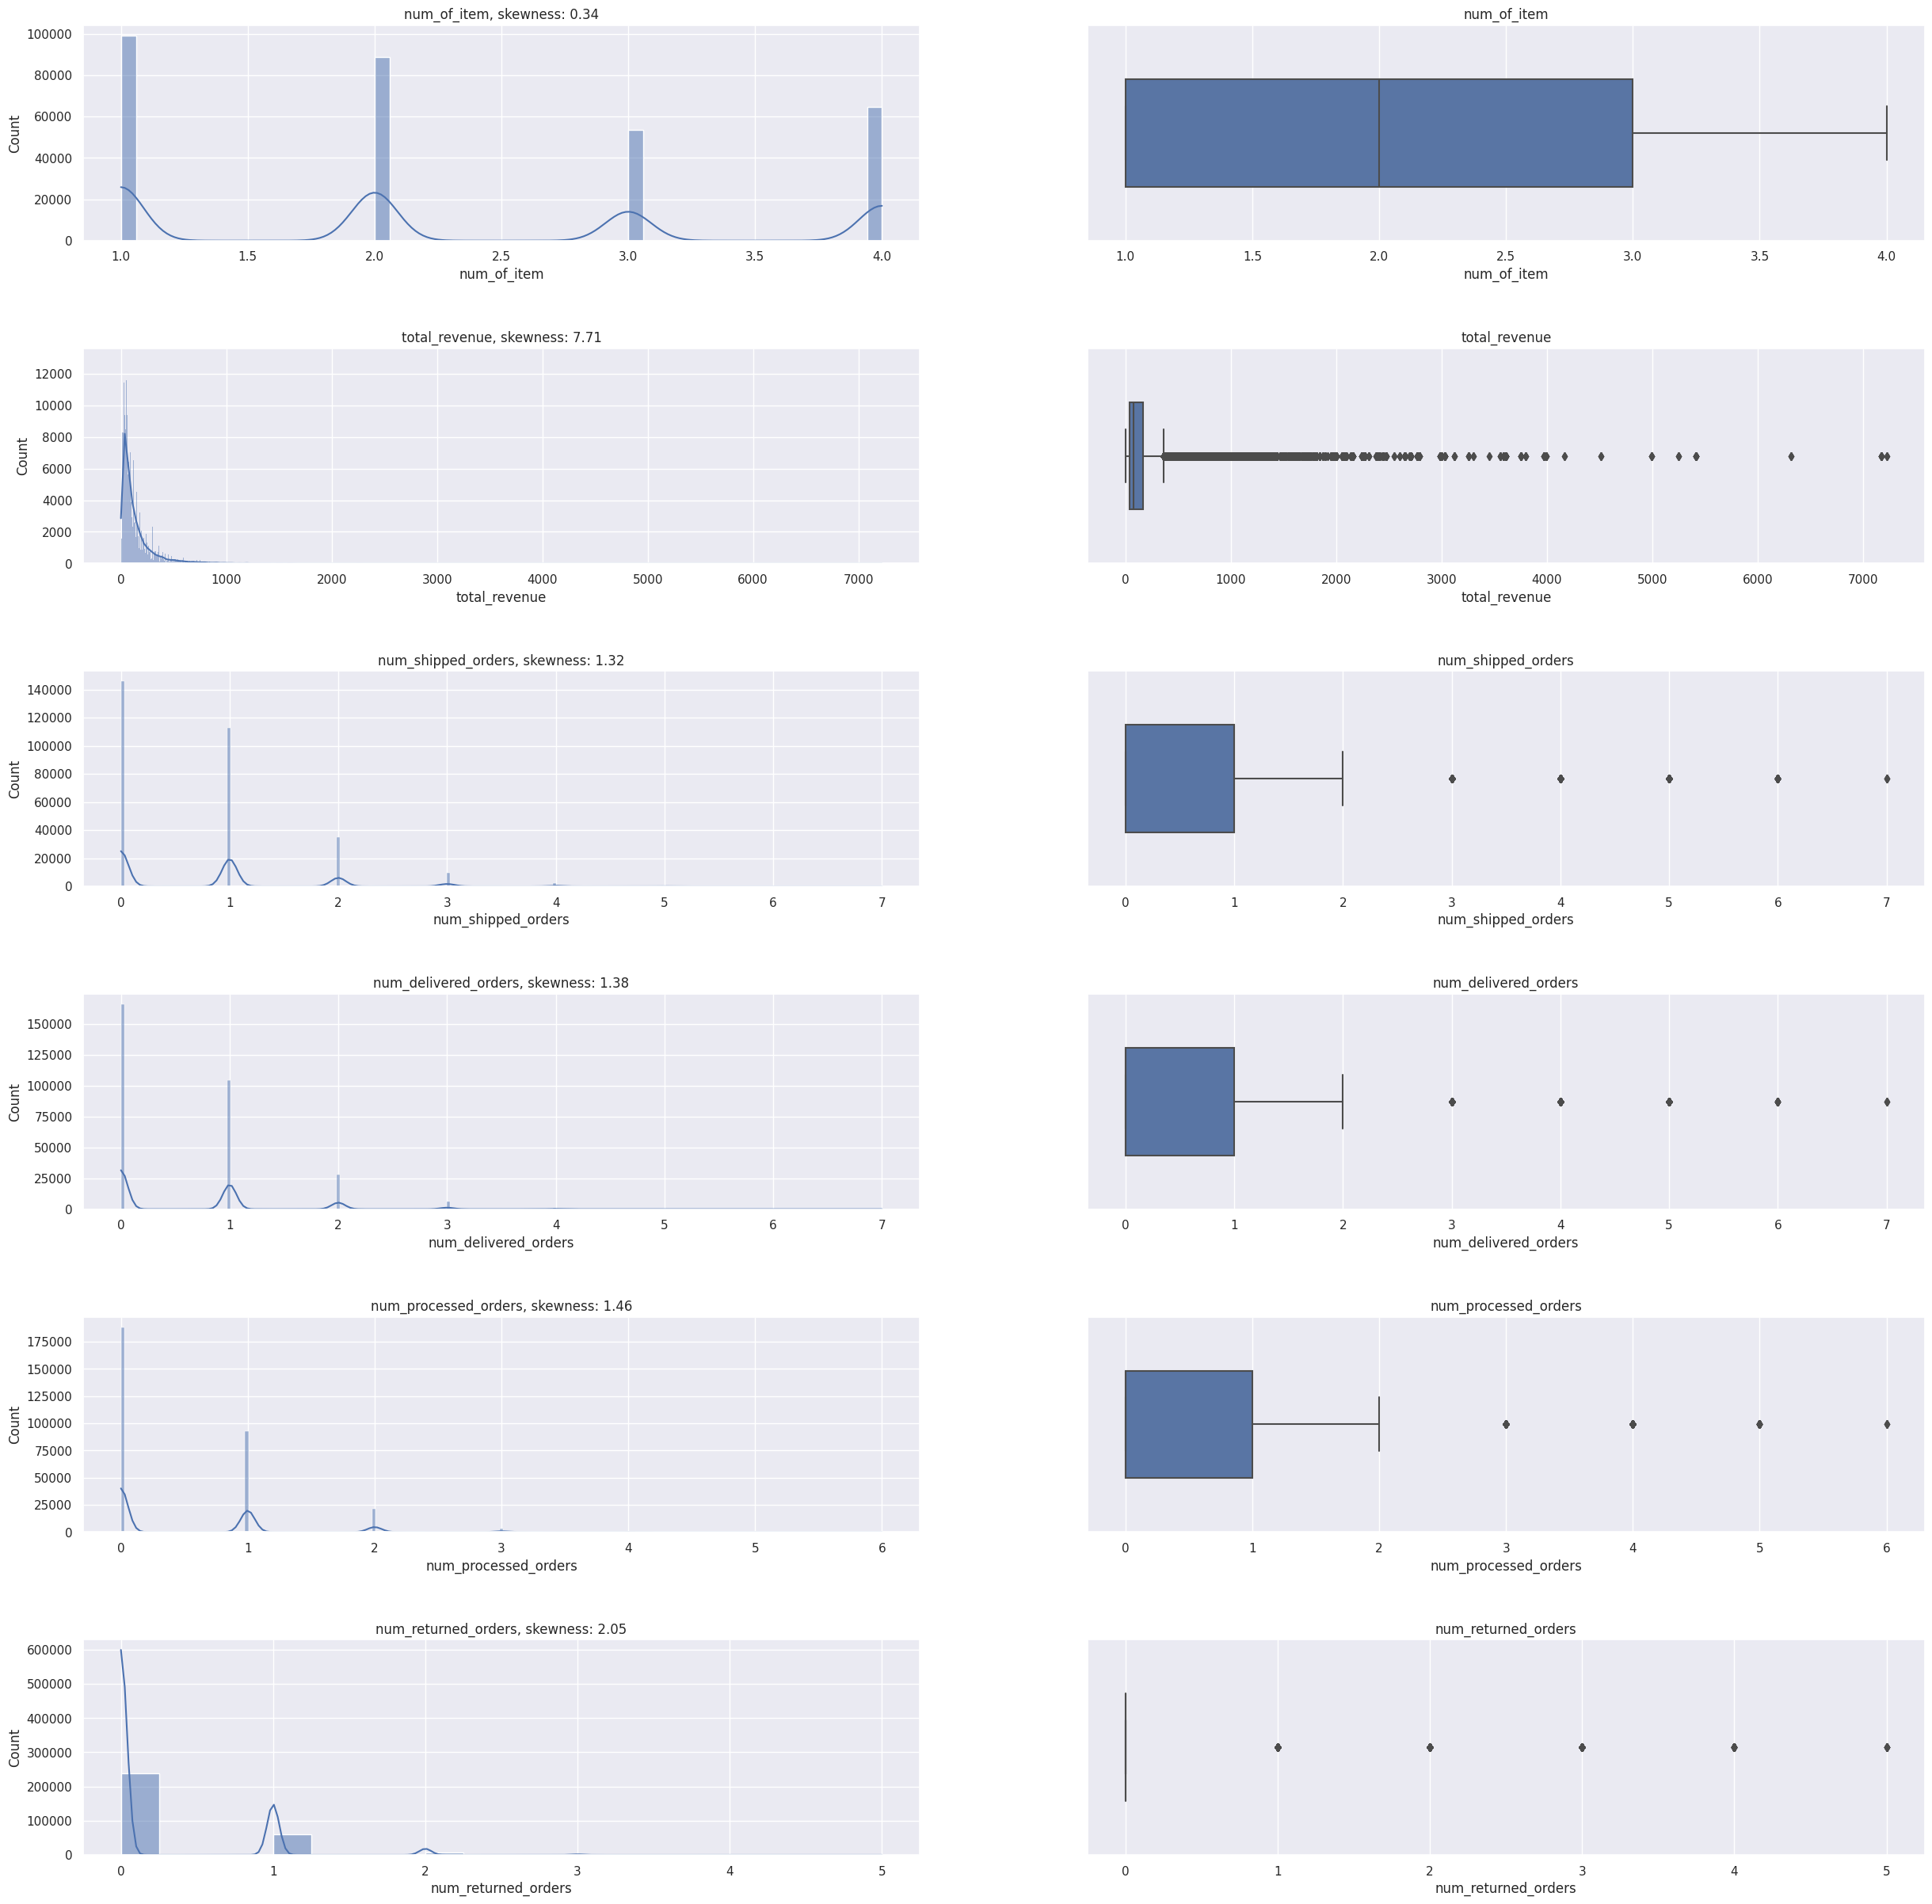

In [136]:
# plot histogram and boxplot
df_eda_num = df_eda_desc[num_columns]
n=len(df_eda_num.columns)
sns.set(font_scale=1)
fig, ax = plt.subplots(n,2,figsize=(30, n * 5))
for i in range(n):
    col = df_eda_num.columns[i]
    sns.histplot(ax=ax[i,0],data=df_eda_num[col],kde=True)
    ax[i,0].set_title(f'{col}, skewness: {round(df_eda_num[col].skew(),2)}')
    sns.boxplot(ax=ax[i,1],data=df_eda_num,x=df_eda_num[col],width=0.50)
    ax[i,1].set_title(col)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [137]:
# Outlier

# Create Function
def outlier_analysis(df,col):
  skewness = df[col].skew()
  if skewness>=-0.5 and skewness<=0.5:
    upper = df[col].mean() + 3*df[col].std()
    lower = df[col].mean() - 3*df[col].std()
  else:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)

  no_outliers = df[(df[col]>=lower) &  (df[col]<=upper)]
  outliers = df[(df[col]>upper ) | (df[col]<lower) ]

  return outliers,no_outliers, upper, lower

# Distribution of Data
def skewness(df,col):
  skewness = df[col].skew()
  if skewness>=-0.5 and skewness<=0.5:
    print(f'Distribution of {col} : Normal Distribution')
  elif skewness<=-0.5:
    print(f'Distribution of {col} : Left Skewed')
  else:
    print(f'Distribution of {col} : Right Skewed')

# percentage of outlier
for i in range(n):
    col = df_eda_num.columns[i]
    out,no_out, up, low = outlier_analysis (df_eda_num,col)
    print(f'column name: {col}')
    skewness (df_eda_num,col)
    print('count of outlier: ', len(out))
    print('percentage of outlier: ', round(((len(out) / len(df_eda_num))) * 100, 2), '%')
    print('skewness: ',round(df_eda_num[col].skew(),2))
    print('-'*20)

column name: num_of_item
Distribution of num_of_item : Normal Distribution
count of outlier:  0
percentage of outlier:  0.0 %
skewness:  0.34
--------------------
column name: total_revenue
Distribution of total_revenue : Right Skewed
count of outlier:  24800
percentage of outlier:  8.1 %
skewness:  7.71
--------------------
column name: num_shipped_orders
Distribution of num_shipped_orders : Right Skewed
count of outlier:  12476
percentage of outlier:  4.08 %
skewness:  1.32
--------------------
column name: num_delivered_orders
Distribution of num_delivered_orders : Right Skewed
count of outlier:  7741
percentage of outlier:  2.53 %
skewness:  1.38
--------------------
column name: num_processed_orders
Distribution of num_processed_orders : Right Skewed
count of outlier:  3978
percentage of outlier:  1.3 %
skewness:  1.46
--------------------
column name: num_returned_orders
Distribution of num_returned_orders : Right Skewed
count of outlier:  66904
percentage of outlier:  21.85 %
sk

Based on the table and visualizations, we can derive some insights regarding the `num_of_item,` `total_revenue,` `num_shipped_orders,` `num_delivered_orders,` `num_processed_orders,` and `num_returned_orders.`

1. Average Number of Items: On average, customers purchase approximately 2.27 items per transaction. This indicates that customers tend to buy more than one item in a single purchase.

2. Average Total Revenue: The average total revenue per transaction is around 145.98. This reflects the average monetary value of each order.

3. Shipping and Delivery Efficiency: On average, 73% of orders are shipped, and 60% are delivered. This suggests that there is room for improvement in ensuring timely deliveries and reducing shipping times.

4. Order Processing Rate: Approximately 48% of orders have been successfully processed. This indicates that some orders might be facing delays or other processing issues.

5. Return Rate: The return rate stands at 25%, suggesting that a quarter of the orders are returned by customers. Reducing returns could be a potential area for improvement in customer satisfaction and cost optimization.

6. Variability in Transaction Size: The data shows that the number of items and total revenue can vary significantly, with a minimum value of 1 item and 0.02 in revenue and a maximum value of 4 items and 7224 in revenue.

7. Spread of Shipping and Order Processing Times: The standard deviations for `num_shipped_orders` and `num_processed_orders` (0.86 and 0.69, respectively) indicate a spread in the time it takes to ship and process orders, implying that some orders may take longer than others.

## 4.5 Best Selling Product Categories

In this section, Exploratory Data Analysis (EDA) is conducted to determine the Best Selling Product Categories.

In [138]:
# By Category
df_group_category = df_eda.groupby('product_category')['total_revenue', 'num_shipped_orders','num_delivered_orders','num_processed_orders','num_returned_orders'].sum().sort_values(by='total_revenue', ascending=False)
df_group_category = df_group_category.rename(columns={'num_shipped_orders': 'shipped','num_delivered_orders':'delivered','num_processed_orders':'processed','num_returned_orders':'returned'})
df_group_category.head(10)

,total_revenue,shipped,delivered,processed,returned
product_category,,,,,
Outerwear & Coats,5.875428e+06,11966.0,9554.0,7737.0,3915.0
Jeans,5.199177e+06,15429.0,13108.0,10649.0,5427.0
Sweaters,3.553441e+06,13958.0,11708.0,9243.0,4569.0
Suits & Sport Coats,2.711674e+06,6544.0,5531.0,4419.0,2222.0
Swim,2.658466e+06,13513.0,11823.0,9624.0,4887.0
Fashion Hoodies & Sweatshirts,2.634038e+06,14406.0,12380.0,9618.0,4890.0
Sleep & Lounge,2.336595e+06,14233.0,11703.0,9354.0,4805.0
Shorts,2.236569e+06,14513.0,11105.0,9600.0,4691.0
Tops & Tees,2.109080e+06,15490.0,12593.0,9805.0,5180.0


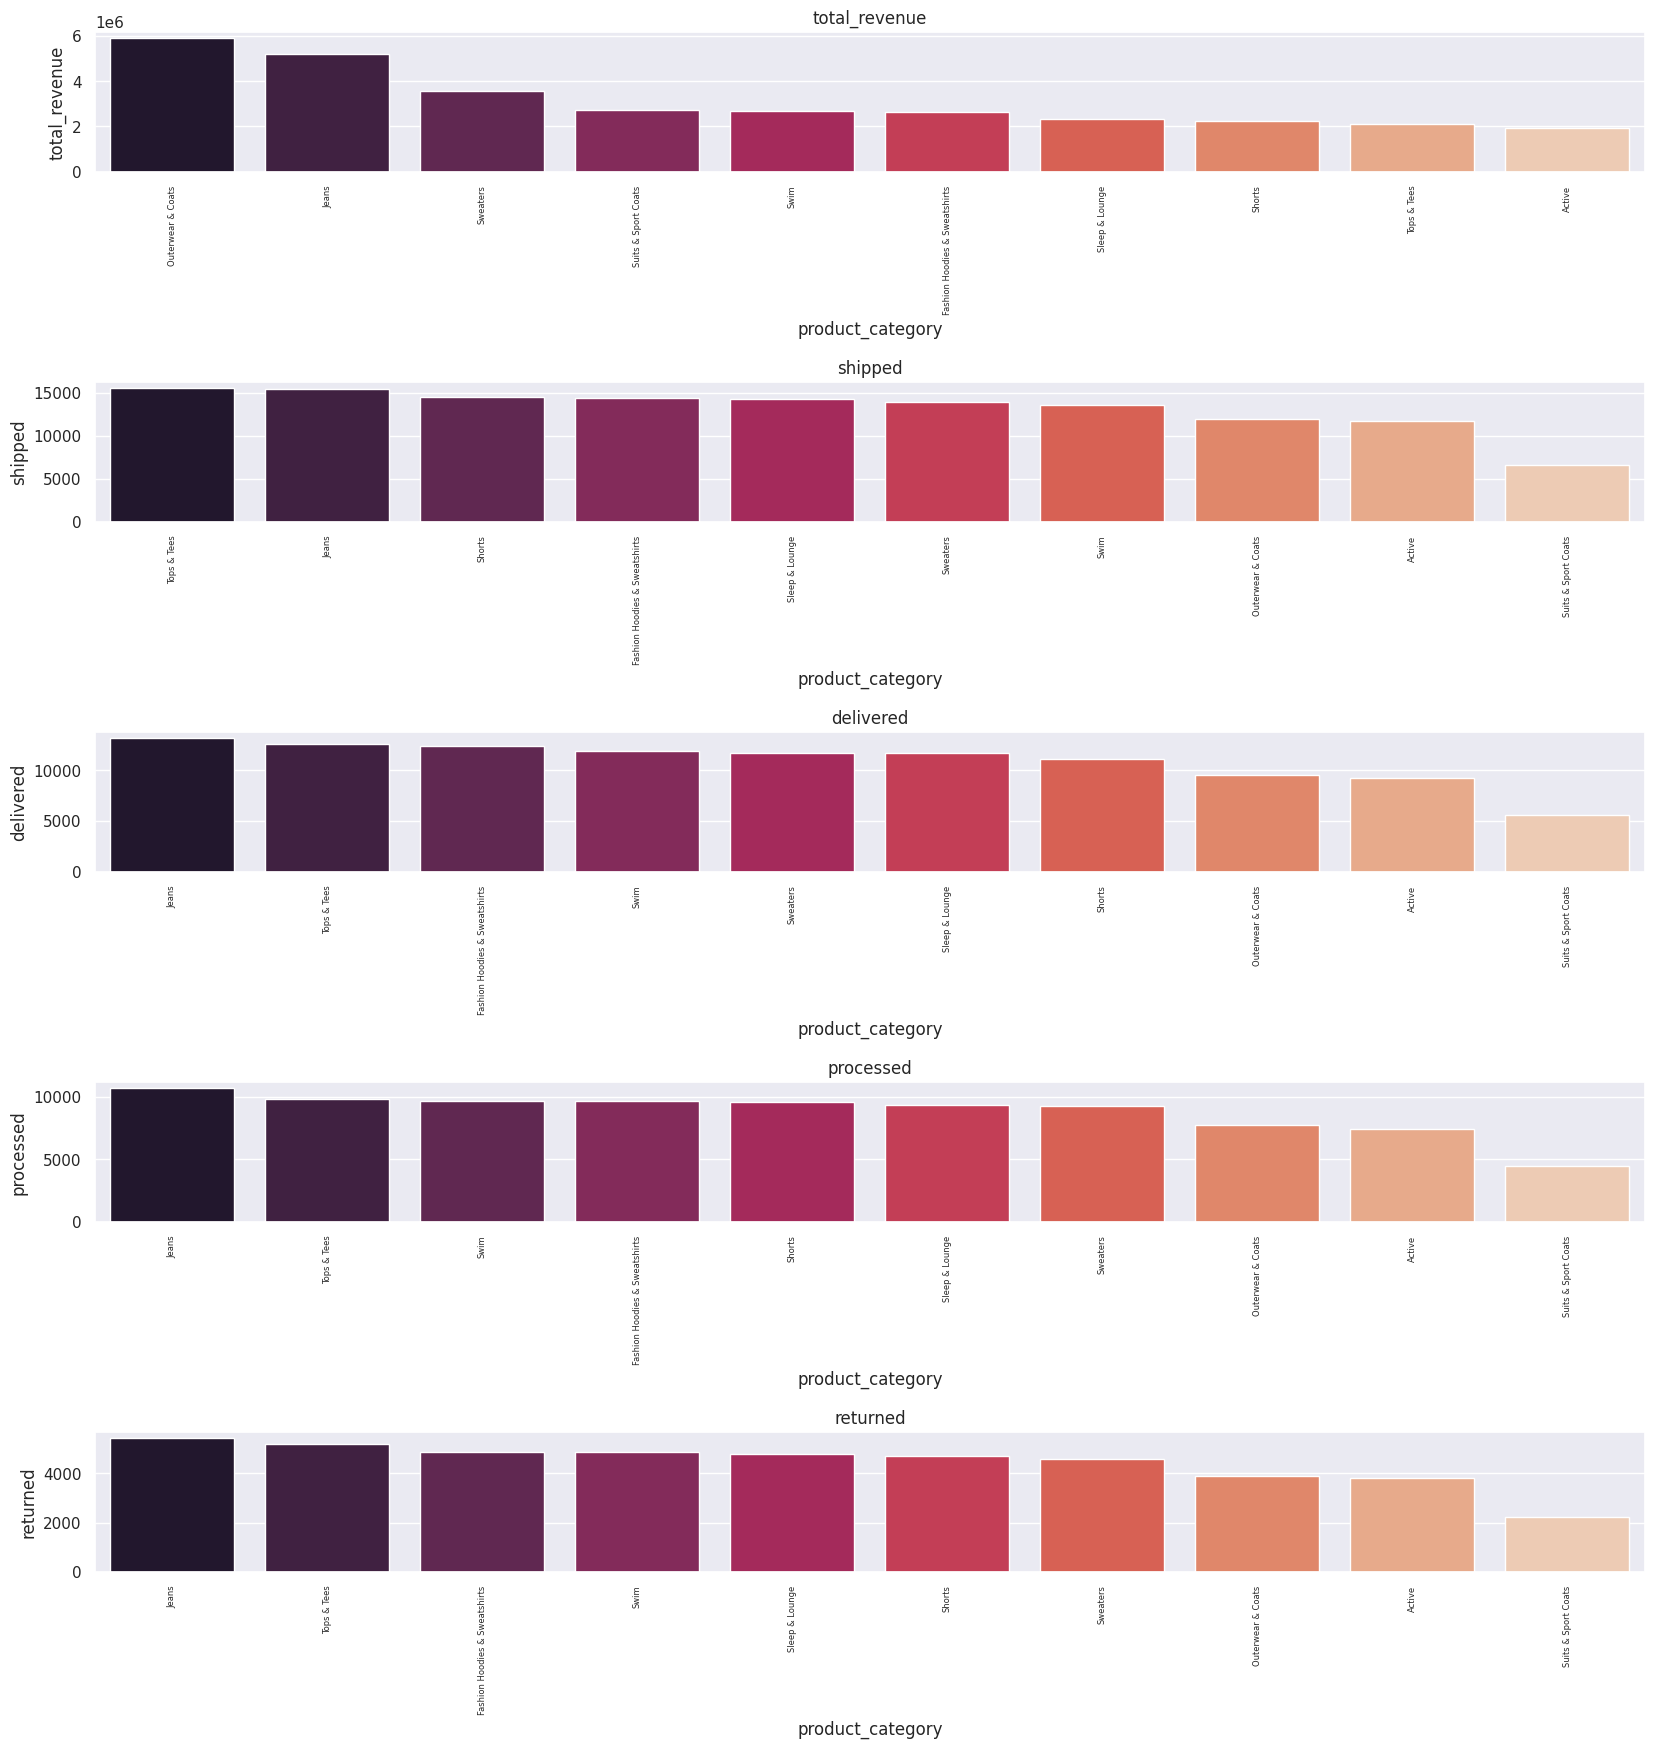

In [139]:
# barplot - product category
n=len(df_group_category.columns)
fig, ax = plt.subplots(n,1,figsize=(20,n*4))

for i in range(n):
    col = df_group_category.columns[i]
    data = df_group_category.head(10)
    sorted_data = data.sort_values(by=col, ascending=False)
    sns.barplot(ax=ax[i],x=sorted_data.index,y=sorted_data[col],palette = palette).set_title(f'{col}')
    ax[i].tick_params(axis='x',labelrotation=90, labelsize=6)

plt.subplots_adjust(hspace=1.5)
plt.show()

Based on the provided data, we can identify the best selling product and the most ordered product for "The Look Ecommerce."

- Best Selling Product Categories: The "**Outerwear & Coats**" category emerges as the best selling product, generating a total revenue of approximately 5.88 million. Customers' strong preference for outerwear and coats contributes significantly to the company's overall revenue, making it a crucial category for sustained profitability. This insight suggests that the company should continue to invest in promoting and optimizing this product category to meet customer demands effectively.

- Most Ordered Product Categories: Although "Outerwear & Coats" is the best selling product, "**Tops & Tees**" stand out as the most ordered product, with a total of 15,490 orders shipped. This implies that while "Outerwear & Coats" generates higher revenue per order, "Tops & Tees" attract a higher number of individual orders. Understanding the popularity of "Tops & Tees" can help "The Look Ecommerce" capitalize on its widespread appeal and adjust inventory levels and marketing strategies accordingly to drive customer satisfaction and repeat purchases.

## 4.6 Best Selling Brand

In this section, Exploratory Data Analysis (EDA) is conducted to determine the Best Selling Brand.

In [140]:
# By Product Brand
df_group_brand = df_eda.groupby('product_brand')['total_revenue', 'num_shipped_orders','num_delivered_orders','num_processed_orders','num_returned_orders'].sum().sort_values(by='total_revenue', ascending=False)
df_group_brand = df_group_brand.rename(columns={'num_shipped_orders': 'shipped','num_delivered_orders':'delivered','num_processed_orders':'processed','num_returned_orders':'returned'})
df_group_brand.head(10)

,total_revenue,shipped,delivered,processed,returned
product_brand,,,,,
Diesel,954834.407997,1900.0,1570.0,1391.0,702.0
Calvin Klein,808896.812717,3952.0,3112.0,2630.0,1373.0
7 For All Mankind,764841.942245,1443.0,1242.0,954.0,520.0
Carhartt,728710.056487,3209.0,2611.0,1966.0,1015.0
True Religion,716990.198521,1009.0,979.0,637.0,360.0
The North Face,537821.040188,386.0,366.0,173.0,83.0
Tommy Hilfiger,505790.559974,2088.0,1825.0,1306.0,755.0
Quiksilver,490511.830273,2619.0,1873.0,1684.0,767.0
Volcom,460875.478313,2358.0,1898.0,1570.0,853.0


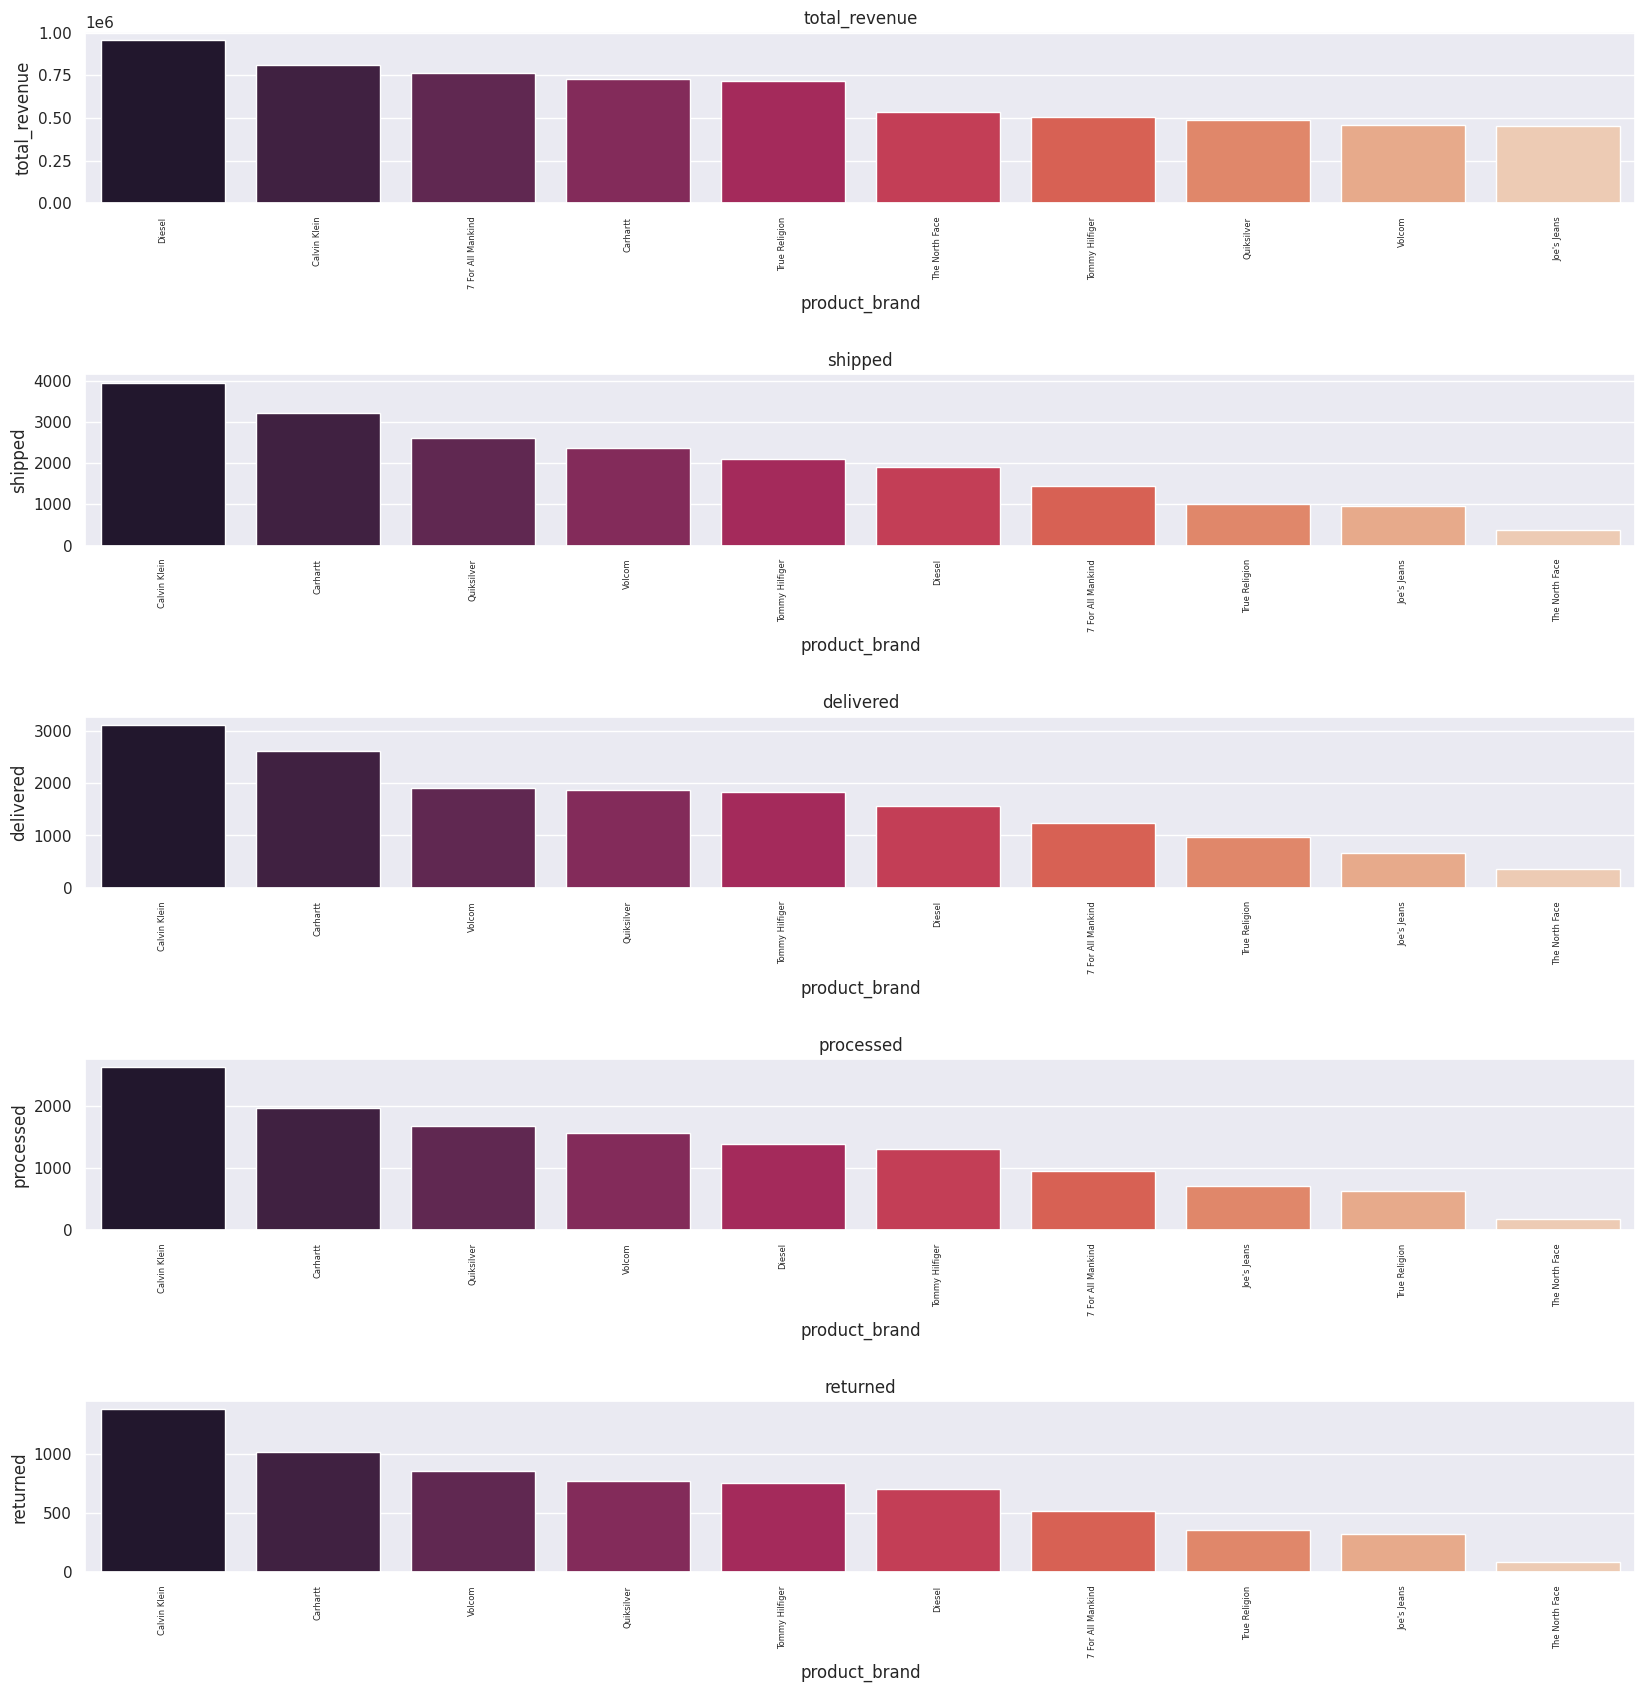

In [141]:
# barplot - product_brand
n=len(df_group_brand.columns)
fig, ax = plt.subplots(n,1,figsize=(20,n*4))

for i in range(n):
    col = df_group_brand.columns[i]
    data = df_group_brand.head(10)
    sorted_data = data.sort_values(by=col, ascending=False)
    sns.barplot(ax=ax[i],x=sorted_data.index,y=sorted_data[col],palette = palette).set_title(f'{col}')
    ax[i].tick_params(axis='x',labelrotation=90, labelsize=6)

plt.subplots_adjust(hspace=1)
plt.show()

Based on the provided data, we can identify the best selling brand and the most ordered brand for "The Look Ecommerce."

- Best Selling Brand: The brand "**Diesel**" emerges as the best selling brand, generating a total revenue of approximately 954,834.41. Customers' strong preference for Diesel products significantly contributes to the company's overall revenue, making it a key brand for sustained profitability. This insight suggests that the company should continue to invest in promoting and optimizing Diesel products to cater to customer demands effectively.

- Most Ordered Brand: Although "Diesel" is the best selling brand, "**Calvin Klein**" stands out as the most ordered brand, with a total of 3,952 orders shipped. This implies that while "Diesel" generates higher revenue per order, "Calvin Klein" attracts a higher number of individual orders. Understanding the popularity of "Calvin Klein" can help "The Look Ecommerce" capitalize on its widespread appeal and adjust inventory levels and marketing strategies accordingly to drive customer satisfaction and repeat purchases.

## 4.7 Best Selling Product

In this section, Exploratory Data Analysis (EDA) is conducted to determine the Best Selling product.

In [142]:
# By Product name
df_group_name = df_eda.groupby('product_name')['total_revenue', 'num_shipped_orders','num_delivered_orders','num_processed_orders','num_returned_orders'].sum().sort_values(by='total_revenue', ascending=False)
df_group_name = df_group_name.rename(columns={'num_shipped_orders': 'shipped','num_delivered_orders':'delivered','num_processed_orders':'processed','num_returned_orders':'returned'})
df_group_name.head(10)

,total_revenue,shipped,delivered,processed,returned
product_name,,,,,
The North Face Apex Bionic Soft Shell Jacket - Men's,146286.000000,40.0,38.0,28.0,20.0
Diesel Men's Lagnum Leather Jacket,124982.000000,55.0,22.0,66.0,22.0
Bergama Natural Raccoon Hooded Stroller - - Multicolor,116998.438477,65.0,13.0,39.0,13.0
The North Face Nuptse 2 Jacket Deep Water Blue Mens,89397.000000,27.0,36.0,36.0,0.0
Canada Goose Men's The Chateau Jacket,63570.000000,18.0,30.0,20.0,6.0
Alpha Industries Rip Stop Short,59940.000000,36.0,18.0,0.0,0.0
Diesel Men's Lisardo Jacket,58366.000000,21.0,7.0,21.0,7.0
Nobis Men's Cartel Jacket,54000.000000,16.0,24.0,24.0,8.0
Barbour Classic Bedale Jacket / Barbour Active Classic Bedale Jacket,53060.000000,30.0,20.0,30.0,30.0


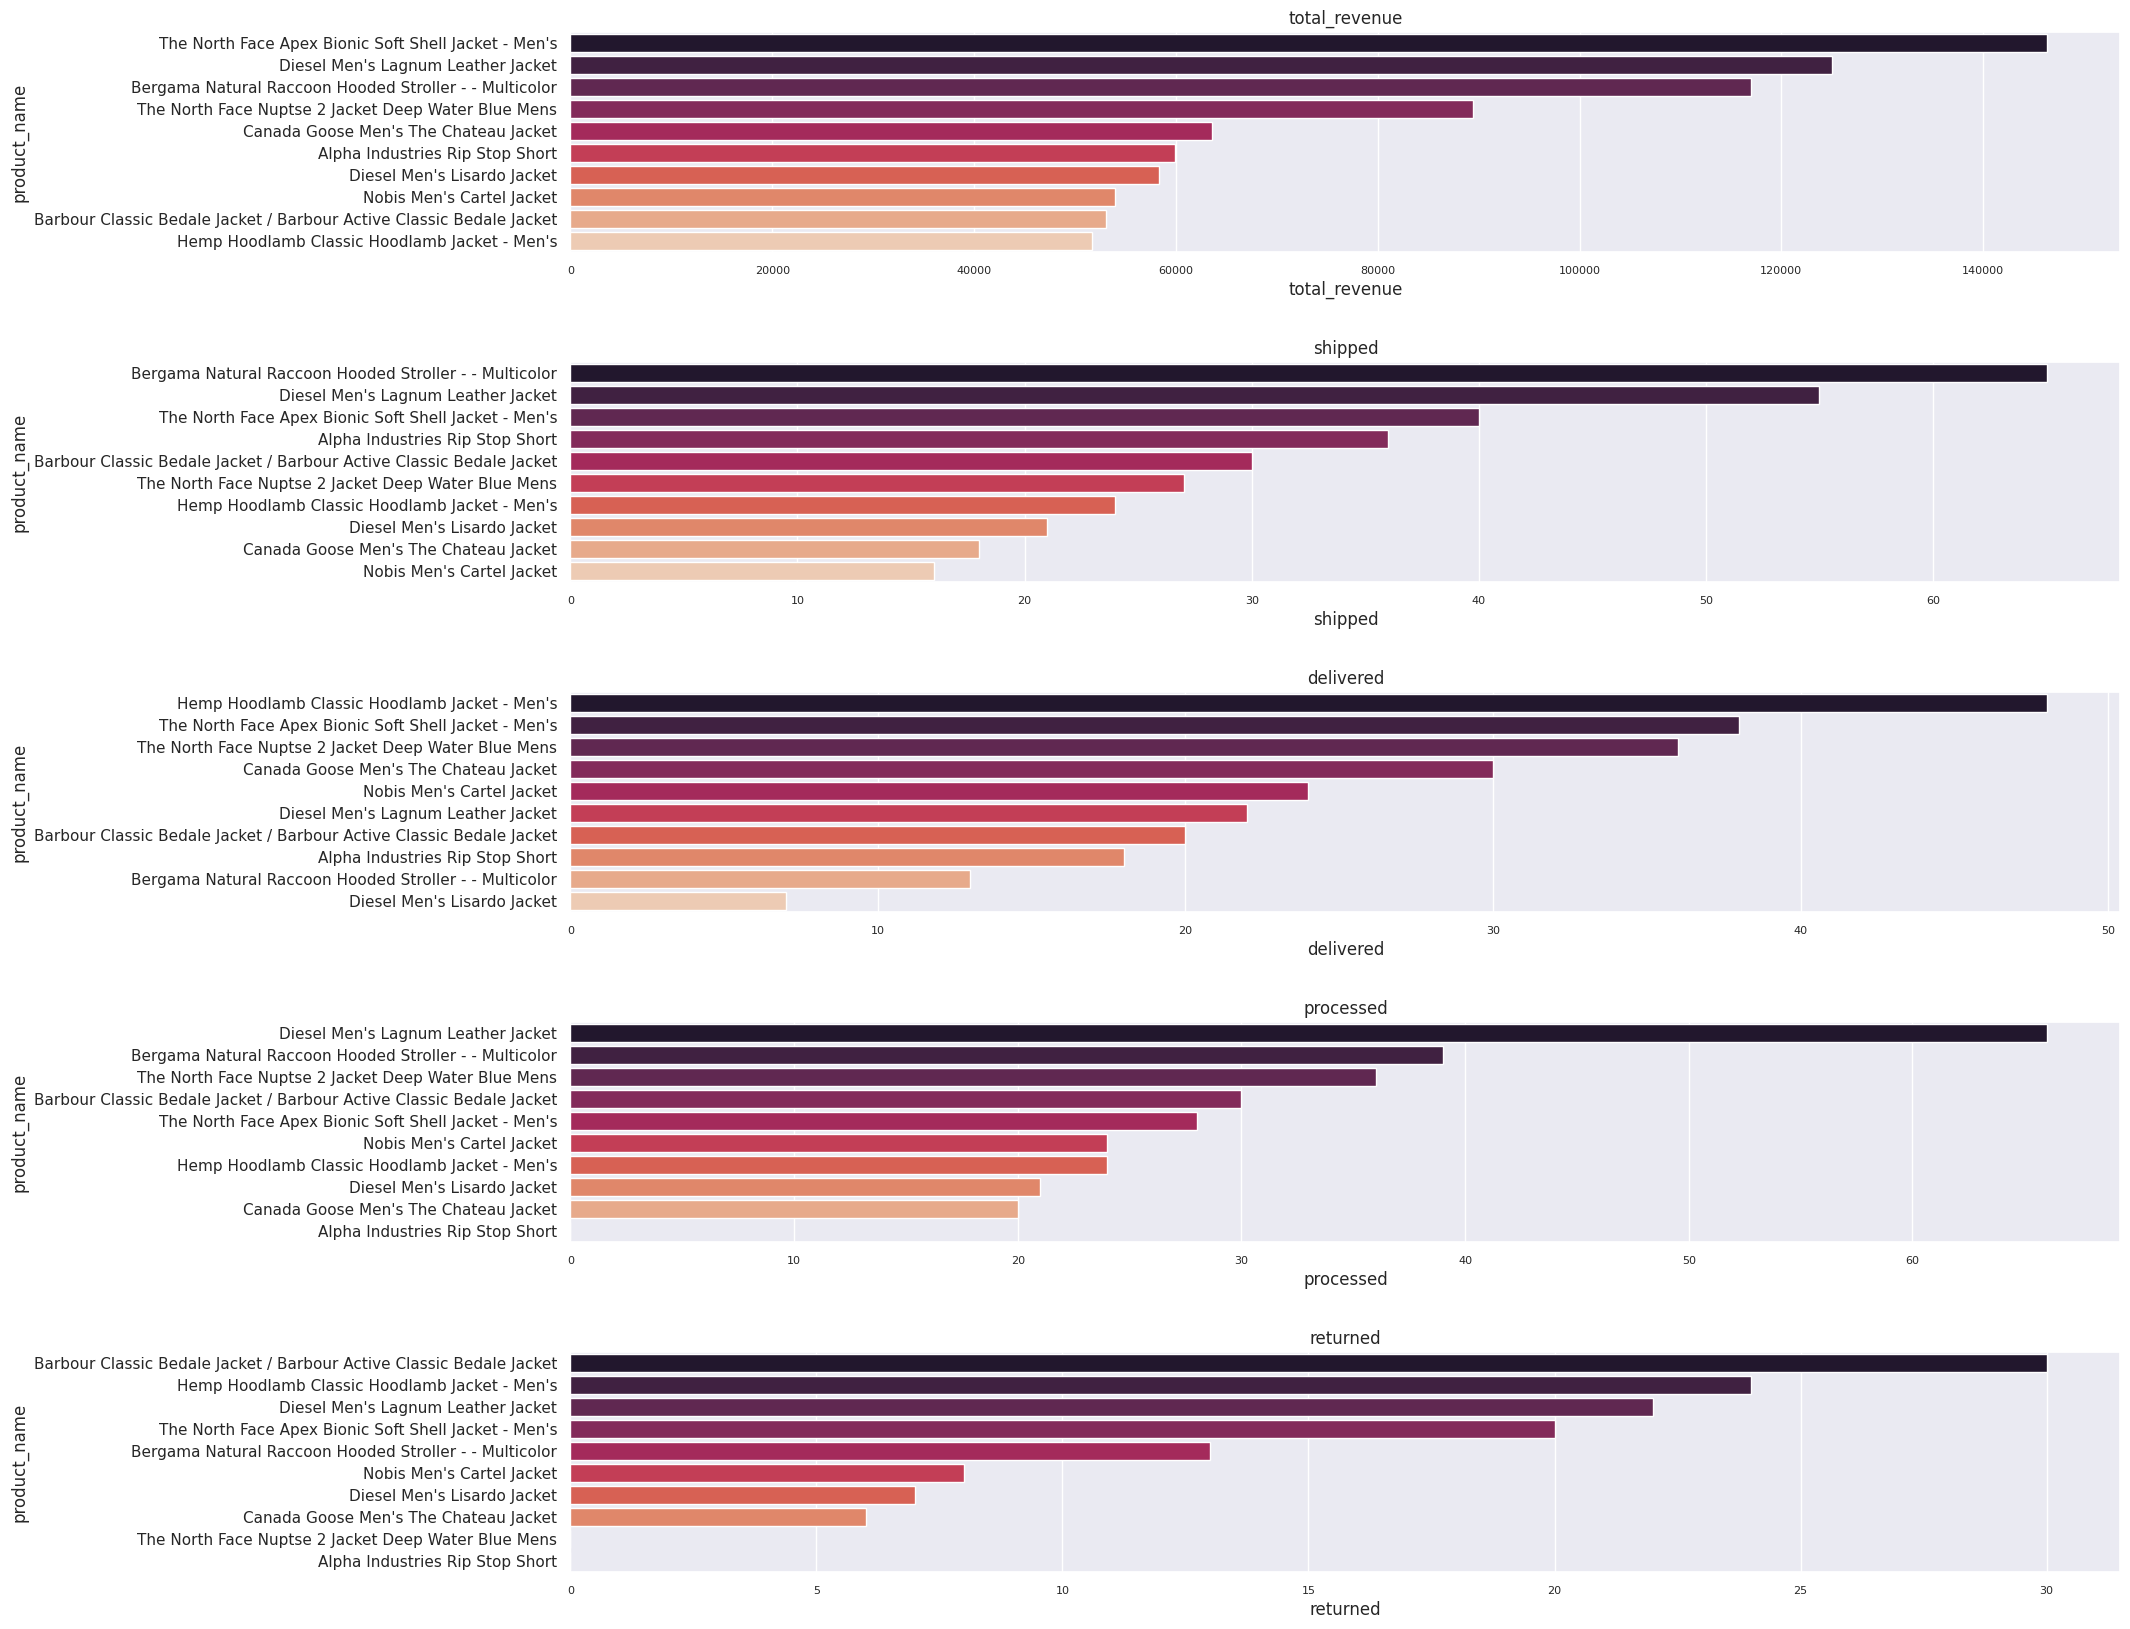

In [143]:
# barplot - product_name
n=len(df_group_name.columns)
fig, ax = plt.subplots(n,1,figsize=(20,n*4))

for i in range(n):
    col = df_group_name.columns[i]
    data = df_group_name.head(10)
    sorted_data = data.sort_values(by=col, ascending=False)
    sns.barplot(ax=ax[i],y=sorted_data.index,x=sorted_data[col],palette = palette).set_title(f'{col}')
    ax[i].tick_params(axis='x',labelrotation=0, labelsize=8)

plt.subplots_adjust(hspace=0.5)
plt.show()

Based on the provided data, we can identify the best selling product and the most ordered product for "The Look Ecommerce."

- Best Selling Product: "**The North Face Apex Bionic Soft Shell Jacket - Men's**" emerges as the best selling product, generating the highest total revenue of approximately 146,286.00. This product's popularity among customers significantly contributes to the company's overall revenue, making it a key item for sustained profitability. The success of this product indicates that customers value its features and are willing to pay a premium for it.

- Most Ordered Product: Although "The North Face Apex Bionic Soft Shell Jacket - Men's" is the best selling product, "**Bergama Natural Raccoon Hooded Stroller - Multicolor**" stands out as the most ordered product, with a total of 65 orders shipped. This implies that while "The North Face Apex Bionic Soft Shell Jacket - Men's" generates higher revenue per order, the "Bergama Natural Raccoon Hooded Stroller" attracts a higher number of individual orders. Understanding the popularity of this product can help "The Look Ecommerce" capitalize on its widespread appeal and adjust inventory levels and marketing strategies accordingly to drive customer satisfaction and repeat purchases.

## 4.8 Inferential Statistics

Hypotheses:

- **Null Hypothesis (H0)**: There is no significant difference in total revenue between the product categories "Intimates" and "Sweaters."
- **Alternative Hypothesis (Ha**): There is a significant difference in total revenue between the product categories "Intimates" and "Sweaters."

In [144]:
# Product categories
intimates_revenue = df_eda[df_eda['product_category'] == 'Intimates']['total_revenue']
sweaters_revenue = df_eda[df_eda['product_category'] == 'Sweaters']['total_revenue']

In [145]:
# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(intimates_revenue, sweaters_revenue, equal_var=True)

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)
print('Total Revenue for Intimates =',intimates_revenue.sum())
print('Total Revenue for Sweaters =',sweaters_revenue.sum())

alpha = 0.05  # Set the significance level

if p_value < alpha:
    print("There is a significant difference in total revenue between the product categories 'Intimates' and 'Sweaters'.")
else:
  print("There is no significant difference in total revenue between the product categories 'Intimates' and 'Sweaters'.")

T-Statistic: -72.22130298009309
P-Value: 0.0
Total Revenue for Intimates = 1670049.6223695278
Total Revenue for Sweaters = 3553440.9404525757
There is a significant difference in total revenue between the product categories 'Intimates' and 'Sweaters'.


# 5 - Conclusion and Recommendation

- Best selling product categories :
  - Best Selling Product Categories: The "Outerwear & Coats" category emerges as the best selling product, generating a total revenue of approximately 5.88 million.
  - Most Ordered Product Categories: Although "Outerwear & Coats" is the best selling product, "Tops & Tees" stand out as the most ordered product, with a total of 15,490 orders shipped.

- Best selling brand :
  - Best Selling Brand: The brand "Diesel" emerges as the best selling brand, generating a total revenue of approximately 954,834.41.
  - Most Ordered Brand: Although "Diesel" is the best selling brand, "Calvin Klein" stands out as the most ordered brand, with a total of 3,952 orders shipped.

- Best selling product :
  - Best Selling Product: "The North Face Apex Bionic Soft Shell Jacket - Men's" emerges as the best selling product, generating the highest total revenue of approximately 146,286.00.

  - Most Ordered Product: Although "The North Face Apex Bionic Soft Shell Jacket - Men's" is the best selling product, "Bergama Natural Raccoon Hooded Stroller - Multicolor" stands out as the most ordered product, with a total of 65 orders shipped.

- Future Improvement :
  - **Promote Top-Selling Brands**: With "Diesel" being the best selling brand, "The Look Ecommerce" can leverage this success to strengthen brand partnerships and highlight Diesel products in marketing campaigns. Simultaneously, for brands with lower revenue but high order frequency, such as "Calvin Klein," targeted promotions and exclusive offers can further boost their popularity and encourage repeat purchases.
  - **Highlight High-Performing Products**: Given the exceptional performance of "The North Face Apex Bionic Soft Shell Jacket - Men's" and "Bergama Natural Raccoon Hooded Stroller - Multicolor," these products should be prominently featured on the website's homepage and in personalized recommendations for customers. This can increase their visibility, leading to more sales and higher revenue.
  
By continuously analyzing customer behavior, purchasing patterns, and product performance, "The Look Ecommerce" can make data-driven decisions to optimize its product assortment. Striving to offer a diverse range of high-quality products while promoting top-performing categories and brands will enhance customer satisfaction, increase repeat business, and position the company as a go-to destination for trendy and in-demand fashion products.